# Modelos QSAR para protease principal 3C-like protease (M<sup>pro</sup>) de SARS-CoV

- Os modelos neste fluxo de trabalho foram gerados usando descritores 2D sirms.py e PaDEL-Descriptor.
- Foram coletados 114 pontos de dados para 113 compostos testados em SARS-CoV Mpro (CHEMBL3927). Os dados foram cuidadosamente selecionados seguindo os protocolos desenvolvidos por Fourches et al. Após a curadoria, 91 compostos (27 ativos e 64 inativos) foram mantidos para modelagem.
- Devido ao tamanho limitado dos dados, validamos os modelos apenas por meio de validação cruzada externa de 5 vezes e aplicamos um limite de 70% de confiança para avaliar os modelos e selecionar resultados para validação experimental.

## Importando Módulos e Funções
         
    

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import _pickle as cPickle
import gzip
from time import time

from BalanceBySim import *
from stats import *
from sklearn.metrics import classification_report, plot_roc_curve, auc

from collections import Counter

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import permutation_test_score, StratifiedKFold

def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
hiper_parametros = 'grid_search' #grid_search, random_search

## Carregar dados

Dados originais:  (113, 11)
Dados mantidos:  (113, 11)


,Compound_name,Standard Type,Standard Relation,Standard Value,Standard Units,Outcome,InChIKey,Molecule ChEMBL ID,ID,SMILES,Mol
count,113,113,113,113,113,113,113,113,113,113,113
unique,74,2,4,94,1,2,113,92,1,113,113
top,,IC50,'=',2.44889419684223E12,nM,Inactive,UUBHDKPSKIQBFE-UHFFFAOYSA-N,,,COc1cccc(-c2[nH]c(SCC(=O)Nc3ccc(C(C)=O)cc3)nc(...,
freq,8,88,89,5,113,73,1,22,113,1,1

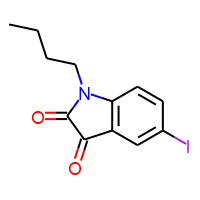

In [19]:
# Definir caminho do arquivo
file = 'datasets/curated_data/chembl-pdb-sars-cov-3C-like-proteinase.sdf.gz'
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
moldf = PandasTools.LoadSDF(file, **sdfInfo)
print('Dados originais: ', moldf.shape)
# Renomear ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
# Remover moléculas RDKit ausentes
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')
# Colunas
print('Dados mantidos: ', moldf.shape)
moldf.describe()

## Forma dos dados

In [20]:
moldf['Outcome'] = moldf['Outcome'].replace('Active', 1)
moldf['Outcome'] = moldf['Outcome'].replace('Inactive', 0)

classes = Counter(moldf['Outcome'])
print('\033[1m' + 'Forma do conjunto de treinamento:' + '\n' + '\033[0m')
for key, value in classes.items():
    print('\t\t Classe %d: %d' % (key, value))
print('\t\t Número total de compostos: %d' % (len(moldf['Outcome'])))

Forma do conjunto de treinamento:

		 Classe 1: 40
		 Classe 0: 73
		 Número total de compostos: 113


# SiRMS

## Descritores de importação

Os descritores foram calculados externamente usando o SiRMS.py. Descritores com baixa variância e correlacionados foram removidos do http://www.qsar4u.com/pages/sirms.php usando o módulo Métodos de Análise de Dados.

In [21]:
desc = pd.read_csv('descriptors/sirms_descritores.csv', sep='\t')
desc.drop(desc.columns[0:2], axis=1,inplace=True)
descriptors = desc.columns.difference(moldf.columns).tolist()
desc.head()

,|S|n|||2|||elm|C#C,|S|n|||2|||elm|C#N,|S|n|||2|||elm|C-C,|S|n|||2|||elm|C-Cl,|S|n|||2|||elm|C-F,|S|n|||2|||elm|C-H,|S|n|||2|||elm|C-I,|S|n|||2|||elm|C-N,|S|n|||2|||elm|C-O,|S|n|||2|||elm|C-S,...,|S|n|||6|||elm|C=C-N(-C-S)-H,|S|n|||6|||elm|C=C-N(-C:C)-H,|S|n|||6|||elm|C=C-N(-C=N)-H,|S|n|||6|||elm|C=C-N-C(:C):C,|S|n|||6|||elm|C=C-N-C(=N)-S,|S|n|||6|||elm|C=C-N-C-S-C,|S|n|||6|||elm|C=C-N-C:C-H,|S|n|||6|||elm|C=C-N-C:C:C,|S|n|||6|||elm|C=C-O-C(-H)-H,|S|n|||6|||elm|H-N(-H)-S(=O)=O
0,0,0,17,0,0,34,0,10,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,8,0,0,31,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,17,0,0,32,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,8,0,0,25,0,4,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,16,0,0,27,0,11,4,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
moldf_desc = pd.concat([moldf,desc], axis=1)
balance_data = 'no'

if balance_data == 'yes':
    # Equilibre os dados usando 1/2 similaridade e 1/2 aleatória
    moldf_desc = BalanceBySim(moldf_desc, 'Outcome', 2)
    # Forma de impressão
    print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))
      
else:
    moldf_desc['Set'] = 'train'
    # Print shape
    print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome']))
    print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))

Forma do conjunto de treinamento: Counter({0: 73, 1: 40})
Forma externa definida: Counter()


In [23]:
moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]

y_train = moldf_train['Outcome'].to_numpy()
X_train = moldf_train[descriptors]
X_train.shape

(113, 4842)

##### Remova variáveis constantes e quase constantes

In [24]:
X_train = X_train.select_dtypes(exclude=['object'])
X_train = X_train.dropna(axis=1, how='any')
X_train = X_train.fillna(0)

# Definir filtro de baixa variação (limite de 10%)
def variance_filter(data, threshold=0.1):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# Aplicar filtro
X_train = variance_filter(X_train)

##### Remover variáveis correlacionadas

In [25]:
%%time
correlated_features = set()  
correlation_matrix = X_train.corr()

for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

X_train.drop(labels=correlated_features, axis=1, inplace=True)

X_train.shape

Wall time: 17.1 s


(113, 394)

In [12]:
X_train.to_csv('descriptors/sirms-chembl-sars-cov-3C-like-proteinase-processed.txt', sep='\t', index=False)

In [28]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Modelo com classificação: {0}".format(i))
            print("Escore médio de validação: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parametros: {0}".format(results['params'][candidate]))
            print("")

## Construção de modelo

##### Encontre os melhores parâmetros

### Pesquisa em grade (Grid Search)

In [29]:
def grid_search(classificador, grid_params, X_train, y_train):
    n_iter_search = 20
    # configuração detalhada = 10 imprimirá o progresso para cada 10 tarefas concluídas
    grid_search = GridSearchCV(classificador, grid_params, n_jobs=-1, cv=5, verbose=1)
    
    start = time()
    grid_search.fit(X_train, y_train)
    print("GridSearchCV levou %.2f segundos para %d candidatos"
      " configurações de parâmetros." % ((time() - start), n_iter_search))

    return grid_search

### Pesquisa aleatória (Random Search)

In [30]:
def random_search(classificador, param_dist, X_train, y_train):
    n_iter_search = 80
    random_search = RandomizedSearchCV(classificador, param_distributions=param_dist, n_iter=n_iter_search, n_jobs=-1, cv=5, verbose=1)
    
    start = time()
    random_search.fit(X_train, y_train)
    print("RandomizedSearchCV levou %.2f segundos para %d candidatos"
      " configurações de parâmetros." % ((time() - start), n_iter_search))
    
    return random_search

### Dados de modelagem

In [31]:
%%time
# Number of trees in random forest
n_estimators = [100, 250, 500, 750, 1000]
max_features = ['auto', 'sqrt']
criterion = ['gini', 'entropy']
if balance_data == 'yes':
    class_weight = [None]
else:
    class_weight = [None,'balanced',
                    {0:.9, 1:.1}, {0:.8, 1:.2}, {0:.7, 1:.3}, {0:.6, 1:.4},
                    {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}]
random_state = [24]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'criterion': criterion,
              'random_state': random_state,
              'class_weight': class_weight}

# Grid Search
rf_grid_sirms = grid_search(RandomForestClassifier(), param_grid, X_train, y_train)
rf_grid_sirms.fit(X_train, y_train)
report(rf_grid_sirms.cv_results_)
print()
print('Grid Search Best params: %s' % rf_grid_sirms.best_params_)
print('Score: %.2f' % rf_grid_sirms.best_score_)

# Random Search
rf_random_sirms = random_search(RandomForestClassifier(), param_grid, X_train, y_train)
rf_random_sirms.fit(X_train, y_train)
report(rf_random_sirms.cv_results_)
print()
print('Random Search Best params: %s' % rf_random_sirms.best_params_)
print('Score: %.2f' % rf_random_sirms.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.9min finished


GridSearchCV levou 358.28 segundos para 20 candidatos configurações de parâmetros.
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.8min finished


Modelo com classificação: 1
Escore médio de validação: 0.797 (std: 0.057)
Parametros: {'class_weight': {0: 0.8, 1: 0.2}, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000, 'random_state': 24}

Modelo com classificação: 1
Escore médio de validação: 0.797 (std: 0.057)
Parametros: {'class_weight': {0: 0.8, 1: 0.2}, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000, 'random_state': 24}

Modelo com classificação: 3
Escore médio de validação: 0.789 (std: 0.073)
Parametros: {'class_weight': {0: 0.8, 1: 0.2}, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 500, 'random_state': 24}

Modelo com classificação: 3
Escore médio de validação: 0.789 (std: 0.073)
Parametros: {'class_weight': {0: 0.8, 1: 0.2}, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 750, 'random_state': 24}

Modelo com classificação: 3
Escore médio de validação: 0.789 (std: 0.073)
Parametros: {'class_weight': {0: 0.8, 1: 0.2}, 'criterion': 'gini', 'max_features': 'sqrt', 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.7min finished


RandomizedSearchCV levou 165.45 segundos para 80 candidatos configurações de parâmetros.
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.4min finished


Modelo com classificação: 1
Escore médio de validação: 0.797 (std: 0.057)
Parametros: {'random_state': 24, 'n_estimators': 1000, 'max_features': 'auto', 'criterion': 'gini', 'class_weight': {0: 0.8, 1: 0.2}}

Modelo com classificação: 1
Escore médio de validação: 0.797 (std: 0.057)
Parametros: {'random_state': 24, 'n_estimators': 1000, 'max_features': 'sqrt', 'criterion': 'gini', 'class_weight': {0: 0.8, 1: 0.2}}

Modelo com classificação: 3
Escore médio de validação: 0.789 (std: 0.073)
Parametros: {'random_state': 24, 'n_estimators': 500, 'max_features': 'sqrt', 'criterion': 'gini', 'class_weight': {0: 0.8, 1: 0.2}}

Modelo com classificação: 3
Escore médio de validação: 0.789 (std: 0.073)
Parametros: {'random_state': 24, 'n_estimators': 750, 'max_features': 'auto', 'criterion': 'gini', 'class_weight': {0: 0.8, 1: 0.2}}

Modelo com classificação: 3
Escore médio de validação: 0.789 (std: 0.073)
Parametros: {'random_state': 24, 'n_estimators': 750, 'max_features': 'sqrt', 'criterion': '

##### Modelo com W/ melhores parâmetros

In [44]:
#criando o modelo com os melhores parametros utilizando processamento paralelo
rf_best = RandomForestClassifier(**rf_random_sirms.best_params_, n_jobs=-1)

#Construa uma floresta de árvores a partir do conjunto de treinamento (X, y)
rf_best.fit(X_train, y_train)

# n_splits: int, padrão = 5 Número de dobras. Deve ser pelo menos 2.
cross_val = StratifiedKFold(n_splits=5)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.8, 1: 0.2}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=24, verbose=0, warm_start=False)

#####  Área sob a curva ROC (AUC) 

In [45]:
def roc_auc(rf_best, cross_val, X_train, y_train):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(10,6))
    for i, (train_index, test_index) in enumerate(cross_val.split(X_train, y_train)):
        rf_best.fit(X_train.iloc[train_index], y_train[train_index])
        viz = plot_roc_curve(rf_best, X_train.iloc[test_index], y_train[test_index],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8, )

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Média ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Característica operacional do receptor")
    ax.legend(loc="lower right")
    plt.show()

##### Validação cruzada 5 vezes Calcular DA

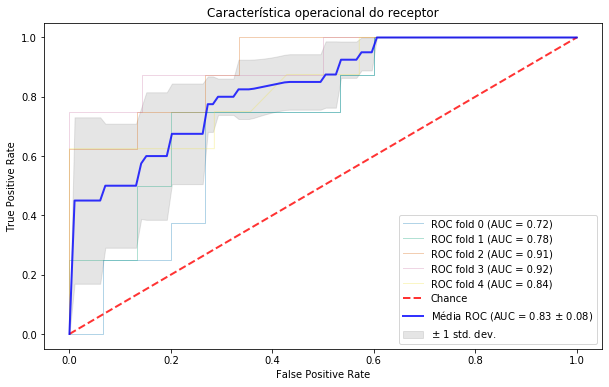

In [46]:
roc_auc(rf_best, cross_val, X_train, y_train)

# Parametros
pred = []
ad = []
index = []
cross_val = StratifiedKFold(n_splits=5)

# Faça um loop de 5 vezes
for train_index, test_index in cross_val.split(X_train, y_train):
    
    fold_model = rf_best.fit(X_train.iloc[train_index], y_train[train_index])
    fold_pred = rf_best.predict(X_train.iloc[test_index])
    fold_ad = rf_best.predict_proba(X_train.iloc[test_index])
    pred.append(fold_pred)
    ad.append(fold_ad)
    index.append(test_index)

In [47]:
threshold_ad = 0.70

# Preparar resultados para exportar   
fold_index = np.concatenate(index)    
fold_pred = np.concatenate(pred)
fold_ad = np.concatenate(ad)
fold_ad = (np.amax(fold_ad, axis=1) >= threshold_ad).astype(str)
five_fold_sirms = pd.DataFrame({'Prediction': fold_pred,'AD': fold_ad}, index=list(fold_index))
five_fold_sirms.AD[five_fold_sirms.AD == 'False'] = np.nan
five_fold_sirms.AD[five_fold_sirms.AD == 'True'] = five_fold_sirms.Prediction
five_fold_sirms.sort_index(inplace=True)
five_fold_sirms['y_train'] = pd.DataFrame(y_train)
five_fold_sirms_ad = five_fold_sirms.dropna().astype(int)
cobertura_5f = len(five_fold_sirms_ad) / len(five_fold_sirms)

# estatísticas de sirms
sirms = pd.DataFrame(stats(five_fold_sirms['y_train'], five_fold_sirms['Prediction']))
sirms['Cobertura'] = 1.0

# estatísticas de sirms AD
sirms_ad = five_fold_sirms.dropna(subset=['AD']).astype(int)
cobertura_sirms_ad = len(sirms_ad['AD']) / len(five_fold_sirms['y_train'])
sirms_ad = pd.DataFrame(stats(sirms_ad['y_train'], sirms_ad['AD']))
sirms_ad['Cobertura'] = round(cobertura_sirms_ad, 2)

# imprimir estatísticas
if hiper_parametros == 'random_search':
    print('\033[1m' + 'Características estatísticas de validação cruzada externa de 5 vezes dos modelos QSAR desenvolvidos SiRMS (random_search)' + '\n' + '\033[0m')
if hiper_parametros == 'grid_search':
    print('\033[1m' + 'Características estatísticas de validação cruzada externa de 5 vezes dos modelos QSAR desenvolvidos SiRMS (grid_search)' + '\n' + '\033[0m')
    
sirms_5f_stats = sirms.append(sirms_ad)
sirms_5f_stats.set_index([['SiRMS', 'SiRMS AD']], drop=True, inplace=True)
sirms_5f_stats

Características estatísticas de validação cruzada externa de 5 vezes dos modelos QSAR desenvolvidos SiRMS (grid_search)



,Kappa,CCR,Sensibilidade,VPP,Especificidade,VPN,Acurácia,F1 Score,Cobertura
SiRMS,0.55,0.77,0.68,0.73,0.86,0.83,0.80,0.70,1.00
SiRMS AD,0.62,0.80,0.68,0.81,0.92,0.85,0.84,0.74,0.65


##### Prever conjunto retido externo após o balanceamento

In [48]:
moldf_ext = moldf_desc[(moldf_desc['Set'] == 'ext')]
descriptor_list = list(X_train.columns.values)

if len(moldf_ext) > 0:
    y_ext = moldf_ext['Outcome'].to_numpy()
    X_ext = moldf_ext[descriptors]
    
    # Filtrar descritores não presentes no modelo
    X_ext = X_ext[descriptor_list]
    
    # Fazer previsões
    ext_set_sirms = rf_best.predict(X_ext)
    ext_set_sirms_ad = rf_best.predict_proba(X_ext)
    ext_set_sirms_ad = (np.amax(ext_set_sirms_ad, axis=1) >= threshold_ad).astype(str)
    
    # Preparar dados
    ext_set_sirms = pd.DataFrame({'Prediction': ext_set_sirms,'AD': ext_set_sirms_ad})
    ext_set_sirms.AD[ext_set_sirms.AD == 'False'] = np.nan
    ext_set_sirms.AD[ext_set_sirms.AD == 'True'] = ext_set_sirms.Prediction
    ext_set_sirms.sort_index(inplace=True)
    ext_set_sirms['y_ext'] = pd.DataFrame(y_ext)
    ext_set_sirms_ad = ext_set_sirms.dropna().astype(int)
    cobertura_ext = len(ext_set_sirms_ad) / len(ext_set_sirms)
    
    # ext_set_sirms estatísticas
    sirms_ext = pd.DataFrame(stats(ext_set_sirms['y_ext'], ext_set_sirms['Prediction']))
    sirms_ext['Cobertura'] = 1.0
    
    # ext_set_sirms AD estatísticas
    sirms_ext_ad = ext_set_sirms.dropna(subset=['AD']).astype(int)
    cobertura_sirms_ext_ad = len(sirms_ext_ad['AD']) / len(ext_set_sirms['y_ext'])
    sirms_ext_ad = pd.DataFrame(stats(sirms_ext_ad['y_ext'], sirms_ext_ad['AD']))
    sirms_ext_ad['Cobertura'] = round(cobertura_sirms_ext_ad, 2)
    
    # imprimir estatísticas
    print('\033[1m' + 'Características estatísticas da previsão do conjunto retido na fonte por modelos SiRMS' + '\n' + '\033[0m')
    ext_set_sirms_stats = sirms_ext.append(sirms_ext_ad)
    ext_set_sirms_stats.set_index([['SiRMS Ext.', 'SiRMS Ext. AD']], drop=True, inplace=True)
    ext_set_sirms_stats
else:
    pass

##### Y-randomization

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


True score =  0.77 
Y-randomization =  0.49 
p-value =  0.0476


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.4min finished


(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d1b60eab88>)

(array([1., 2., 2., 0., 1., 0., 2., 5., 4., 3.]),
 array([0.38 , 0.397, 0.414, 0.431, 0.448, 0.465, 0.482, 0.499, 0.516,
        0.533, 0.55 ]),
 <a list of 10 Patch objects>)

(0.0, 5.25)

Text(0.5, 0, 'Score')

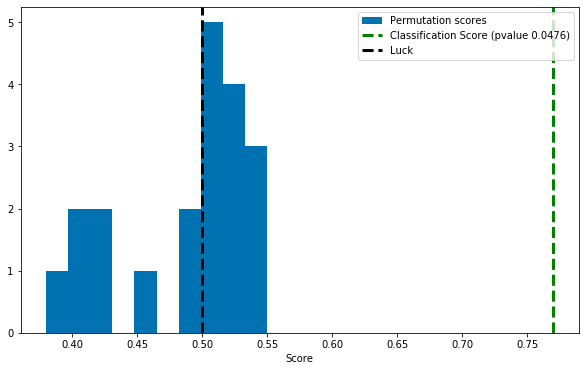

In [49]:
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(rf_best, X_train, y_train,
                                                           cv=5, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))


###############################################################################
# View histogram of permutation scores
plt.subplots(figsize=(10,6))
plt.hist(permutation_scores.round(2), label='Permutation scores')
ylim = plt.ylim()
plt.vlines(score, ylim[0], ylim[1], linestyle='--',
          color='g', linewidth=3, label='Classification Score'
          ' (pvalue %s)' % pvalue.round(4))
plt.vlines(1.0 / 2, ylim[0], ylim[1], linestyle='--',
          color='k', linewidth=3, label='Luck')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

##### Salvar modelo

In [47]:
with gzip.GzipFile('model/sars-cov-3clpro-sirms_RF_ad_balanced.pgz', 'w') as f:
    cPickle.dump(rf_best, f)

### Estatísticas de plotagem

In [50]:
# Exportar estatísticas
if len(moldf_ext) > 0:
    sirms_stats = pd.concat([sirms_5f_stats, ext_set_sirms_stats], axis=0)
    sirms_stats
else:
    sirms_stats = sirms_5f_stats.copy()

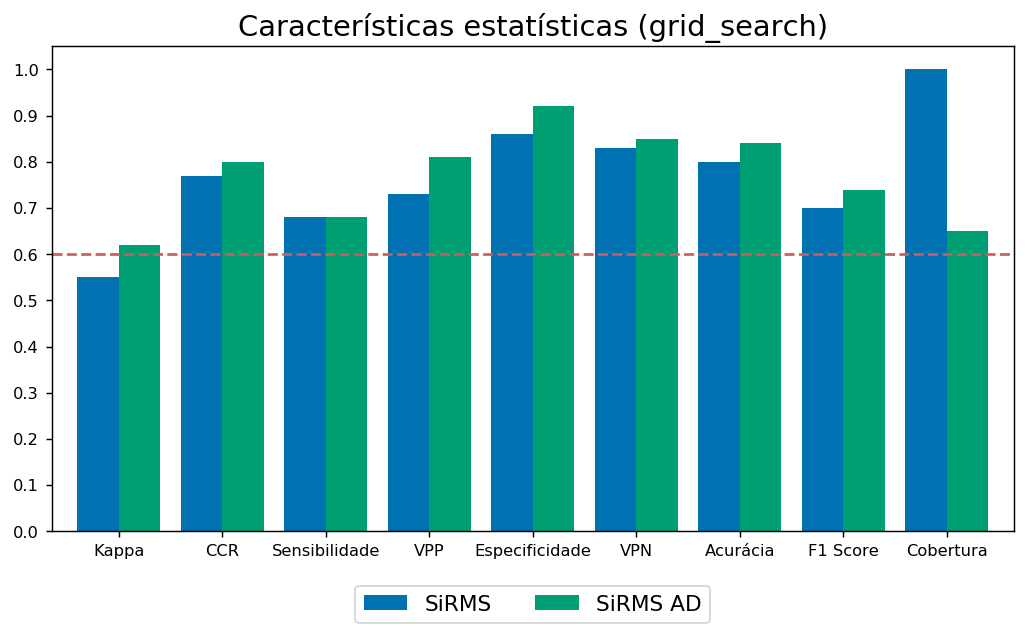

In [51]:
# Estatísticas de transposição
sirms_stats_t = sirms_stats.T
sirms_stats_t = sirms_stats_t.reset_index()
sirms_stats_t = sirms_stats_t.rename(columns={'index': 'Stats'})

# Fazer enredo
plt.style.use('seaborn-colorblind')
fig, ax1 = plt.subplots(figsize=(8,5), dpi=130)

sirms_stats_t.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xticklabels(labels=sirms_stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')
ax1.legend_.remove()
if hiper_parametros == 'random_search':
    plt.title('Características estatísticas (random_search)', fontsize=16)
if hiper_parametros == 'grid_search':
    plt.title('Características estatísticas (grid_search)', fontsize=16)    
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=9)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=12,
            loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=4)
fig.tight_layout()

plt.savefig('statistics-sirms.png', bbox_inches='tight', transparent=False, format='png', dpi=300)
plt.show();

# PaDEL-Descriptor

## Descritores de importação

Os descritores foram calculados externamente usando o PaDEL-Descriptor

In [52]:
desc = pd.read_csv('descriptors/descritores_padel.csv', sep=',')
desc.drop(desc.columns[0:1], axis=1,inplace=True)
descriptors = desc.columns.difference(moldf.columns).tolist()
desc.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,0,-4.2977,18.470225,132.8391,84.652513,0,0,80,39,41,...,6.891334,75.570741,1.937711,38.322507,17.432368,20.890140,5667.0,54.0,-1.209,182.0
1,0,-1.7673,3.123349,69.7047,81.390169,20,21,71,38,33,...,7.257246,76.720926,2.018972,29.983053,7.558586,22.424467,4373.0,60.0,4.283,200.0
2,0,-2.3517,5.530493,111.7482,80.756927,5,5,76,37,39,...,6.859160,71.610666,1.935423,35.344750,15.491789,19.852961,4915.0,51.0,1.144,174.0
3,0,-1.4399,2.073312,48.8548,70.796204,18,18,60,32,28,...,7.136833,64.813560,2.025424,13.685079,7.585620,6.099459,3270.0,42.0,9.673,154.0
4,2,-5.9759,35.711381,117.1793,89.082134,6,6,83,45,38,...,7.689817,87.562513,1.945834,46.951878,29.497872,17.454006,7960.0,62.0,-2.633,208.0


In [53]:
moldf_desc = pd.concat([moldf,desc], axis=1)
balance_data = 'no'

if balance_data == 'yes':
    # Equilibre os dados usando 1/2 similaridade e 1/2 aleatória
    moldf_desc = BalanceBySim(moldf_desc, 'Outcome', 2)
    # Forma de impressão
    print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))
      
else:
    moldf_desc['Set'] = 'train'
    # Forma de impressão
    print('Forma do conjunto de treinamento: %s' % Counter(moldf_desc['Outcome']))
    print('Forma externa definida: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))

Forma do conjunto de treinamento: Counter({0: 73, 1: 40})
Forma externa definida: Counter()


In [56]:
moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]

y_train = moldf_train['Outcome'].to_numpy()
X_train = moldf_train[descriptors]
X_train.shape

(113, 1444)

##### Remover variáveis constantes e quase constantes

In [57]:
X_train = X_train.select_dtypes(exclude=['object'])
X_train = X_train.dropna(axis=1, how='any')
X_train = X_train.fillna(0)

# Definir filtro de baixa variação (limite de 10%)
def variance_filter(data, threshold=0.1):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# Aplicar filtro
X = variance_filter(X_train)

##### Remover variáveis correlacionadas

In [ ]:
correlated_features = set()  
correlation_matrix = X_train.corr()

for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

X_train.drop(labels=correlated_features, axis=1, inplace=True)

X_train.shape

In [ ]:
X_train.to_csv('descriptors/padel-chembl-sars-cov-3C-like-proteinase-processed.txt', sep='\t', index=False)

## Construção de modelo

### Dados de modelagem

##### Encontre os melhores parâmetros

In [ ]:
if balance_data == 'yes':
    class_weight = [None]
else:
    class_weight = [None,'balanced',
                    {0:.9, 1:.1}, {0:.8, 1:.2}, {0:.7, 1:.3}, {0:.6, 1:.4},
                    {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}]

param_grid = {'criterion': ['entropy', 'gini'],
               'max_features': ['auto', 'sqrt','log2'],
               'class_weight': class_weight,
               'random_state': [0, 24],
               'min_samples_split':[2,5,10],
               'min_samples_leaf':[1,2,4],
               'bootstrap' : [True,False],
               'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

# Grid Search
rf_grid_padel = grid_search(RandomForestClassifier(), param_grid, X_train, y_train)
rf_grid_padel.fit(X_train, y_train)
report(rf_grid_padel.cv_results_)
print()
print('Grid Search Best params: %s' % rf_grid_padel.best_params_)
print('Score: %.2f' % rf_grid_padel.best_score_)

# Random Search
rf_random_padel = random_search(RandomForestClassifier(), param_grid, X_train, y_train)
rf_random_padel.fit(X_train, y_train)
report(rf_random_padel.cv_results_)
print()
print('Random Search Best params: %s' % rf_random_padel.best_params_)
print('Score: %.2f' % rf_random_sirms.best_score_)

##### Modelo com / melhores parâmetros

In [93]:
#criando o modelo com os melhores parametros utilizando processamento paralelo
rf_best = RandomForestClassifier(**rf_grid_padel.best_params_, n_jobs=-1)

#Construa uma floresta de árvores a partir do conjunto de treinamento (X, y)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=87, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=933,
                       n_jobs=-1, oob_score=False, random_state=24, verbose=0,
                       warm_start=False)

##### Validação cruzada 5 vezes

In [96]:
roc_auc(rf_best, cross_val, X_train, y_train)

# Parametros
pred = []
ad = []
index = []
cross_val = StratifiedKFold(n_splits=5)

# Faça um loop de 5 vezes
for train_index, test_index in cross_val.split(X_train, y_train):
    
    fold_model = rf_best.fit(X_train.iloc[train_index], y_train[train_index])
    fold_pred = rf_best.predict(X_train.iloc[test_index])
    fold_ad = rf_best.predict_proba(X_train.iloc[test_index])
    pred.append(fold_pred)
    ad.append(fold_ad)
    index.append(test_index)

threshold_ad = 0.70

# Preparar resultados para exportar    
fold_index = np.concatenate(index)    
fold_pred = np.concatenate(pred)
fold_ad = np.concatenate(ad)
fold_ad = (np.amax(fold_ad, axis=1) >= threshold_ad).astype(str)
five_fold_padel = pd.DataFrame({'Prediction': fold_pred,'AD': fold_ad}, index=list(fold_index))
five_fold_padel.AD[five_fold_padel.AD == 'False'] = np.nan
five_fold_padel.AD[five_fold_padel.AD == 'True'] = five_fold_padel.Prediction
five_fold_padel.sort_index(inplace=True)
five_fold_padel['y_train'] = pd.DataFrame(y_train)
five_fold_padel_ad = five_fold_padel.dropna().astype(int)
cobertura_5f = len(five_fold_padel_ad) / len(five_fold_padel)

# estatísticas padel
padel = pd.DataFrame(stats(five_fold_padel['y_train'], five_fold_padel['Prediction']))
padel['Cobertura'] = 1.0

# estatísticas padel AD
padel_ad = five_fold_padel.dropna(subset=['AD']).astype(int)
cobertura_padel_ad = len(padel_ad['AD']) / len(five_fold_padel['y_train'])
padel_ad = pd.DataFrame(stats(padel_ad['y_train'], padel_ad['AD']))
padel_ad['Cobertura'] = round(cobertura_padel_ad, 2)

# imprimir estatísticas
if hiper_parametros == 'random_search':
    print('\033[1m' + 'Características estatísticas de validação cruzada externa de 5 vezes dos modelos QSAR desenvolvidos PaDEL (random_search)' + '\n' + '\033[0m')
if hiper_parametros == 'grid_search':
    print('\033[1m' + 'Características estatísticas de validação cruzada externa de 5 vezes dos modelos QSAR desenvolvidos PaDEL (grid_search)' + '\n' + '\033[0m')
padel_5f_stats = padel.append(padel_ad)
padel_5f_stats.set_index([['PaDEL', 'PaDEL AD']], drop=True, inplace=True)
padel_5f_stats

Características estatísticas de validação cruzada externa de 5 vezes dos modelos QSAR desenvolvidos PaDEL (grid_search)



,Kappa,CCR,Sensibilidade,PPV,Especificidade,NPV,Accuracy,F1 Score,Cobertura
PaDEL,0.47,0.73,0.62,0.68,0.84,0.80,0.76,0.65,1.00
PaDEL AD,0.86,0.90,0.80,1.00,1.00,0.95,0.96,0.89,0.43


##### Prever conjunto retido externo após o balanceamento

In [97]:
moldf_ext = moldf_desc[(moldf_desc['Set'] == 'ext')]
descriptor_list = list(X_train.columns.values)

if len(moldf_ext) > 0:
    y_ext = moldf_ext['Outcome'].to_numpy()
    X_ext = moldf_ext[descriptors]
    
    # Filtrar descritores não presentes no modelo
    X_ext = X_ext[descriptor_list]
    
    # Fazer previsões
    ext_set_padel = rf_best.predict(X_ext)
    ext_set_padel_ad = rf_best.predict_proba(X_ext)
    ext_set_padel_ad = (np.amax(ext_set_padel_ad, axis=1) >= threshold_ad).astype(str)
    
    # Preparar dados
    ext_set_padel = pd.DataFrame({'Prediction': ext_set_padel,'AD': ext_set_padel_ad})
    ext_set_padel.AD[ext_set_padel.AD == 'False'] = np.nan
    ext_set_padel.AD[ext_set_padel.AD == 'True'] = ext_set_padel.Prediction
    ext_set_padel.sort_index(inplace=True)
    ext_set_padel['y_ext'] = pd.DataFrame(y_ext)
    ext_set_padel_ad = ext_set_padel.dropna().astype(int)
    cobertura_ext = len(ext_set_padel_ad) / len(ext_set_padel)
    
    # ext_set_padel estatísticas
    padel_ext = pd.DataFrame(stats(ext_set_padel['y_ext'], ext_set_padel['Prediction']))
    padel_ext['Cobertura'] = 1.0
    
    # ext_set_padel AD stats
    padel_ext_ad = ext_set_padel.dropna(subset=['AD']).astype(int)
    cobertura_padel_ext_ad = len(padel_ext_ad['AD']) / len(ext_set_padel['y_ext'])
    padel_ext_ad = pd.DataFrame(stats(padel_ext_ad['y_ext'], padel_ext_ad['AD']))
    padel_ext_ad['Cobertura'] = round(cobertura_padel_ext_ad, 2)
    
    # imprimir estatísticas
    print('\033[1m' + 'Características estatísticas da previsão do conjunto retido na fonte por modelos PaDEL' + '\n' + '\033[0m')
    ext_set_padel_stats = padel_ext.append(padel_ext_ad)
    ext_set_padel_stats.set_index([['PaDEL Ext.', 'PaDEL Ext. AD']], drop=True, inplace=True)
    ext_set_padel_stats
else:
    pass

##### Y-randomization

In [98]:
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(rf_best, X_train, y_train,
                                                           cv=5, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))


###############################################################################
# View histogram of permutation scores
pl.subplots(figsize=(10,6))
pl.hist(permutation_scores.round(2), label='Permutation scores')
ylim = pl.ylim()
pl.vlines(score, ylim[0], ylim[1], linestyle='--',
          color='g', linewidth=3, label='Classification Score'
          ' (pvalue %s)' % pvalue.round(4))
pl.vlines(1.0 / 2, ylim[0], ylim[1], linestyle='--',
          color='k', linewidth=3, label='Luck')
pl.ylim(ylim)
pl.legend()
pl.xlabel('Score')
pl.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


True score =  0.73 
Y-randomization =  0.5 
p-value =  0.0476


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished


##### Salvar modelo

In [99]:
with gzip.GzipFile('model/sars-cov-3clpro-padel_RF_ad_balanced.pgz', 'w') as f:
    cPickle.dump(rf_best, f)

### Plotar estatísticas

In [100]:
# Exportar estatísticas
if len(moldf_ext) > 0:
    padel_stats = pd.concat([padel_5f_stats, ext_set_padel_stats], axis=0)
    padel_stats
else:
    padel_stats = padel_5f_stats.copy()
    padel_stats

,Kappa,CCR,Sensibilidade,PPV,Especificidade,NPV,Accuracy,F1 Score,Cobertura
PaDEL,0.47,0.73,0.62,0.68,0.84,0.80,0.76,0.65,1.00
PaDEL AD,0.86,0.90,0.80,1.00,1.00,0.95,0.96,0.89,0.43


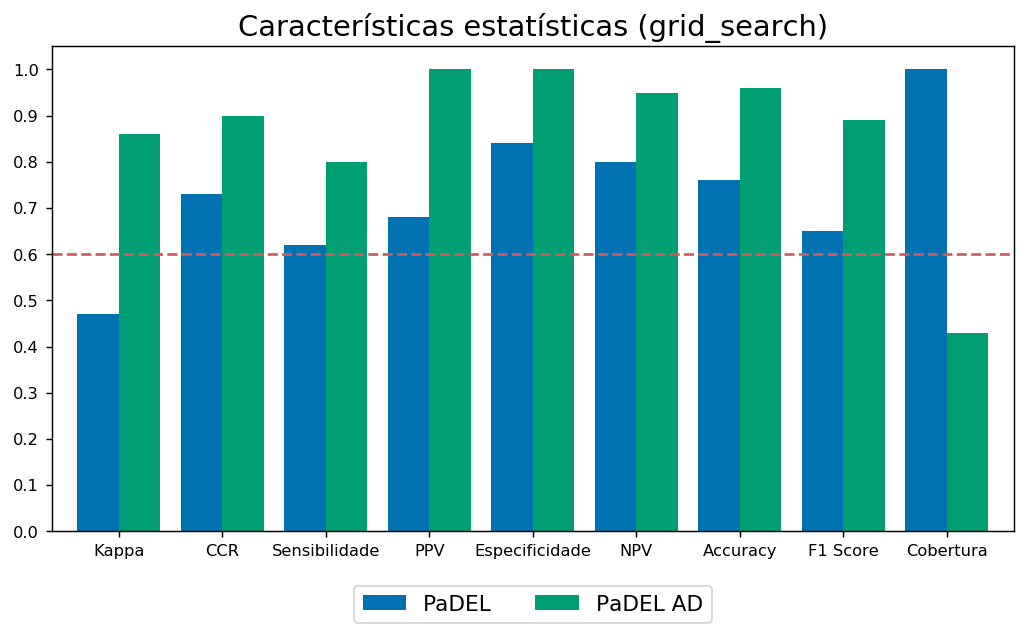

In [101]:
# Estatísticas de transposição
padel_stats_t = padel_stats.T
padel_stats_t = padel_stats_t.reset_index()
padel_stats_t = padel_stats_t.rename(columns={'index': 'Stats'})

# Fazer enredo
plt.style.use('seaborn-colorblind')
fig, ax1 = plt.subplots(figsize=(8,5), dpi=130)

padel_stats_t.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xticklabels(labels=padel_stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')
ax1.legend_.remove()
if hiper_parametros == 'random_search':
    plt.title('Características estatísticas (random_search)', fontsize=16)
if hiper_parametros == 'grid_search':
    plt.title('Características estatísticas (grid_search)', fontsize=16)  
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=9)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=12,
            loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=4)
fig.tight_layout()

plt.savefig('statistics-padel.png', bbox_inches='tight', transparent=False, format='png', dpi=300)
plt.show();

# Consenso

In [102]:
results_sirms = five_fold_sirms.drop(columns='y_train')
results_sirms = five_fold_sirms.rename(columns={'Prediction':'sirms', 'AD':'sirms_ad'})
results_padel = five_fold_padel.drop(columns='y_train')
results_padel = five_fold_padel.rename(columns={'Prediction':'padel', 'AD':'padel_ad'})

In [103]:
var = list(moldf.columns.values)
moldf_train = moldf_train[var]
predictions = pd.concat([moldf_train.reset_index(drop=True), results_sirms, results_padel], axis=1)

#### Previsões de consenso

In [104]:
# Consenso
predictions['consensus'] = (predictions.sirms + predictions.padel)/2
predictions['consensus'] = np.where(predictions['consensus'] > 0.5, 1, 0)

# Consenso AD
for i in range(0, predictions.shape[0]):
    if all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.padel_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.padel_ad[i])/2
        predictions.loc[i,'consensus_ad'] = np.where(predictions.loc[i,'consensus_ad'] > 0.5, 1, 0)
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.padel_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = predictions.padel_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.padel_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = predictions.sirms_ad[i]
    else:
        predictions.loc[i,'consensus_ad']  = np.nan

# Rigor de consenso
for i in range(0, predictions.shape[0]):
    if all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.padel_ad[i]) == False]):
        predictions.loc[i,'consensus_rigor'] = (predictions.sirms_ad[i] + predictions.padel_ad[i])/2
        predictions.loc[i,'consensus_rigor'] = np.where(predictions.loc[i,'consensus_rigor'] > 0.5, 1, 0)
    else:
        predictions.loc[i,'consensus_rigor']  = np.nan
        
predictions.drop(columns=['y_train', 'ID'], inplace=True)

In [105]:
##### SiRMS

# Estatísticas SiRMS
sirms = pd.DataFrame(stats(predictions.Outcome, predictions.sirms))
sirms['Cobertura'] = 1.0

# Estatísticas SiRMS AD
sirms_ad = predictions.dropna(subset=['sirms_ad'])
cobertura_sirms_ad = len(sirms_ad.sirms_ad) / len(predictions.Outcome)
sirms_ad = pd.DataFrame(stats(sirms_ad.Outcome, sirms_ad.sirms_ad.astype(int)))
sirms_ad['Cobertura'] = round(cobertura_sirms_ad, 2)

##### PaDEL

# estatísticas de padel
padel = pd.DataFrame(stats(predictions.Outcome, predictions.padel))
padel['Cobertura'] = 1.0

# estatísticas de padel AD
padel_ad = predictions.dropna(subset=['padel_ad'])
cobertura_padel_ad = len(padel_ad.padel_ad) / len(predictions.Outcome)
padel_ad = pd.DataFrame(stats(padel_ad.Outcome, padel_ad.padel_ad.astype(int)))
padel_ad['Cobertura'] = round(cobertura_padel_ad, 2)

##### Consenso

# estatísticas consenso
consensus = pd.DataFrame(stats(predictions.Outcome, predictions.consensus))
consensus['Cobertura'] = 1.0

# estatísticas consenso AD
consensus_ad = predictions.dropna(subset=['consensus_ad'])
cobertura_consensus_ad = len(consensus_ad.consensus_ad) / len(predictions.Outcome)

consensus_ad = pd.DataFrame(stats(consensus_ad.Outcome, consensus_ad.consensus_ad.astype(int)))
consensus_ad['Cobertura'] = round(cobertura_consensus_ad, 2)

# estatísticas rigor do consenso
consensus_rigor = predictions.dropna(subset=['consensus_rigor'])
cobertura_consensus_rigor = len(consensus_rigor.consensus_rigor) / len(predictions.Outcome)
consensus_rigor = pd.DataFrame(stats(consensus_rigor.Outcome, consensus_rigor.consensus_rigor.astype(int)))
consensus_rigor['Cobertura'] = round(cobertura_consensus_rigor, 2)

##### Previsões de exportação

In [106]:
pred_exp = predictions.drop(columns=['Mol'])

with pd.ExcelWriter('predictions-sirms-padel.xlsx') as writer:
    pred_exp.to_excel(writer, sheet_name='sirms-padel', index=False)

##### Estatísticas

In [107]:
stats = pd.concat([sirms_ad, padel_ad, consensus, consensus_ad, consensus_rigor], axis=0)
stats.set_index([['SiRMS', 'PaDEL', 'Consenso', 'Consenso (AD)', 'Consenso com rigor']], drop=True, inplace=True)

stats

,Kappa,CCR,Sensibilidade,PPV,Especificidade,NPV,Accuracy,F1 Score,Cobertura
SiRMS,0.63,0.80,0.69,0.82,0.91,0.84,0.84,0.75,0.65
PaDEL,0.86,0.90,0.80,1.00,1.00,0.95,0.96,0.89,0.43
Consenso,0.57,0.77,0.62,0.81,0.92,0.82,0.81,0.70,1.00
Consenso (AD),0.68,0.82,0.70,0.86,0.94,0.86,0.86,0.78,0.71
Consenso com rigor,0.85,0.89,0.78,1.00,1.00,0.94,0.95,0.88,0.37


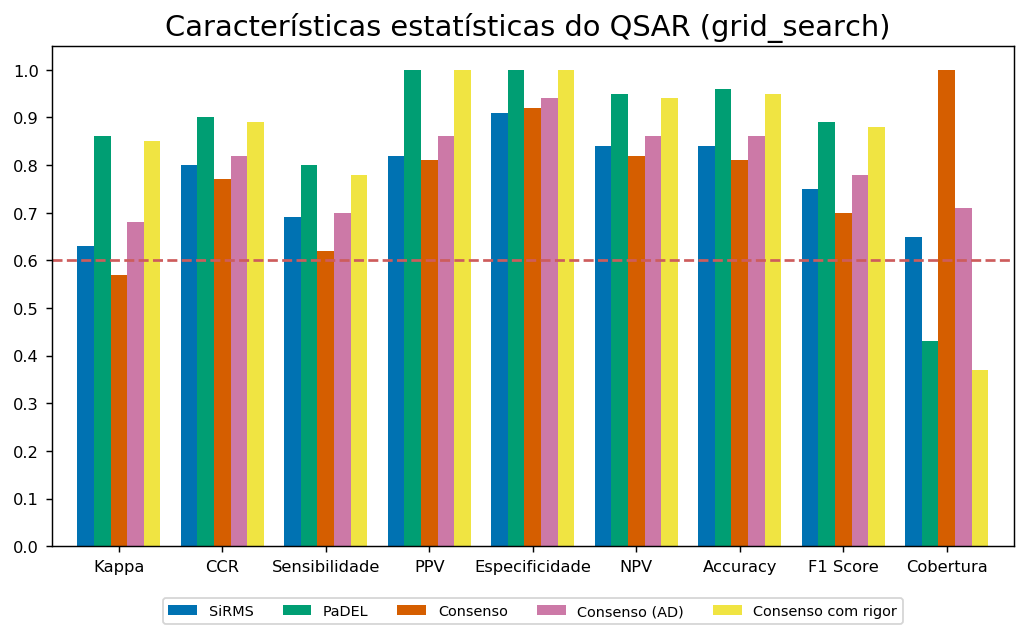

In [108]:
# Estatísticas de transposição
stats_t = stats.T
stats_t = stats_t.reset_index()
stats_t = stats_t.rename(columns={'index': 'Stats'})

# Fazer plot
plt.style.use('seaborn-colorblind')
fig, ax1 = plt.subplots(figsize=(8,5), dpi=130)

stats_t.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xticklabels(labels=stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')
ax1.legend_.remove()
if hiper_parametros == 'random_search':
    plt.title('Características estatísticas do QSAR (random_search) ', fontsize=16)
if hiper_parametros == 'grid_search':
    plt.title('Características estatísticas do QSAR (grid_search) ', fontsize=16)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=9)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=8,
            loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=5)
fig.tight_layout()

plt.savefig('statistics-sirms-padel-5f.png', bbox_inches='tight', transparent=False, format='png', dpi=300)
plt.show();